In [113]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
y = mnist.target

In [33]:
X = mnist.data.reshape(70000, 1, 28, 28)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

In [65]:
class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()

        self.features = torch.nn.Sequential(                    # inp: B 1 28 28
            torch.nn.Conv2d(1, 32, 3, stride=1, padding=0),     # B 32 26 26
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=1, padding=0),    # B 32 24 24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 32 12 12
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=0),    # B 64 10 10
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=1, padding=0),    # B 64 8 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 64 4 4
            torch.nn.Conv2d(64, 128, 3, stride=1, padding=0),   # B 128 2 2
            torch.nn.ReLU(),
        )

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * 128, 128),                      # B 128
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)                            # B 10
        )

        self.log_prob_cal = torch.nn.LogSoftmax(dim=-1)
    
    def forward(self, b_x, b_y=None):
        conv_features = self.features(b_x)
        class_scores = self.decider(conv_features.flatten(1))
        log_probs = self.log_prob_cal(class_scores)
        loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(log_probs, dim=-1)
        return decision, loss

In [108]:
model = MyModel()
model.cuda()

MyModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
  )
  (decider): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (log_prob_cal): LogSoftmax(dim=-1)
)

In [109]:
for n, v in model.named_parameters():
    print(n)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
decider.1.weight
decider.1.bias
decider.3.weight
decider.3.bias


In [111]:
batch_size = 64
batch_x_placeholder = torch.zeros(size=[batch_size, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size=[batch_size], dtype=torch.long, device=torch.device('cuda:0'))
epochs = 50
iters_per_epoch = 100
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))

In [112]:
optimizer = torch.optim.Adam(filter(
    lambda p: p.requires_grad, model.parameters()), lr=0.001
)

In [115]:
iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))
val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train()

    # shuffling
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)

    epoch_loss = 0
    tps = 0

    # iterate over training set
    for iter in range(iters_per_epoch):
        batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

        # reshape placeholder
        if len(batch_indices) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_indices), 1, 28, 28])
            batch_y_placeholder.resize_([len(batch_indices)])

        batch_x_placeholder.copy_(torch.Tensor(X_train[batch_indices, :, :, :]))
        batch_y_placeholder.copy_(torch.Tensor(y_train[batch_indices].astype(int)))

        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        b_decision = b_decision.cpu().numpy()

        epoch_loss += float(b_loss) / iters_per_epoch
        tps += np.sum(y_train[batch_indices].astype(int) == b_decision)

        b_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    epoch_train_accuracy = tps * 100.0 / len(X_train)
    train_loss[e] = epoch_loss
    train_acc[e] = epoch_train_accuracy

    # validating over validation set
    with torch.no_grad():
        model.eval()

        # shuffling
        val_indices = np.arange(len(X_val))
        np.random.shuffle(val_indices)

        val_epoch_loss = 0
        val_tps = 0

        for iter in range(val_iters_per_epoch):
            val_batch_indices = val_indices[iter * batch_size: min(len(val_indices), (iter + 1) * batch_size)]

            # reshape placeholder
            if len(val_batch_indices) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_indices), 1, 28, 28])
                batch_y_placeholder.resize_([len(val_batch_indices)])
            
            batch_x_placeholder.copy_(torch.Tensor(X_val[val_batch_indices]))
            batch_y_placeholder.copy_(torch.Tensor(y_val[val_batch_indices].astype(int)))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            val_epoch_loss += float(b_loss) / iters_per_epoch
            val_tps += np.sum(y_val[val_batch_indices].astype(int) == b_decision)

        epoch_val_accuracy = val_tps * 100.0 / len(X_val)
        val_loss[e] = val_epoch_loss
        val_acc[e] = epoch_val_accuracy

    #saving model
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'epoch_loss': epoch_loss,
            'epoch_train_accuracy': epoch_train_accuracy,
            'val_epoch_loss': val_epoch_loss,
            'epoch_val_accuracy': epoch_val_accuracy
        }, f'MNIST/epoch_{e}_state.pt')

    print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {val_epoch_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')

Epoch 0 finished in 3.18s. loss: 0.0686 - acc: 97.89 - val loss: 0.0124 - val acc: 98.49
Epoch 1 finished in 3.12s. loss: 0.0558 - acc: 98.40 - val loss: 0.0122 - val acc: 98.52
Epoch 2 finished in 3.10s. loss: 0.0455 - acc: 98.63 - val loss: 0.0108 - val acc: 98.77
Epoch 3 finished in 3.06s. loss: 0.0395 - acc: 98.85 - val loss: 0.0107 - val acc: 98.76
Epoch 4 finished in 3.10s. loss: 0.0328 - acc: 99.02 - val loss: 0.0099 - val acc: 98.96
Epoch 5 finished in 3.08s. loss: 0.0336 - acc: 98.99 - val loss: 0.0126 - val acc: 98.61
Epoch 6 finished in 3.07s. loss: 0.0285 - acc: 99.13 - val loss: 0.0104 - val acc: 99.01
Epoch 7 finished in 3.08s. loss: 0.0281 - acc: 99.12 - val loss: 0.0090 - val acc: 98.96
Epoch 8 finished in 3.09s. loss: 0.0239 - acc: 99.26 - val loss: 0.0109 - val acc: 98.89
Epoch 9 finished in 3.05s. loss: 0.0246 - acc: 99.24 - val loss: 0.0108 - val acc: 98.91
Epoch 10 finished in 3.08s. loss: 0.0254 - acc: 99.28 - val loss: 0.0108 - val acc: 98.92
Epoch 11 finished in

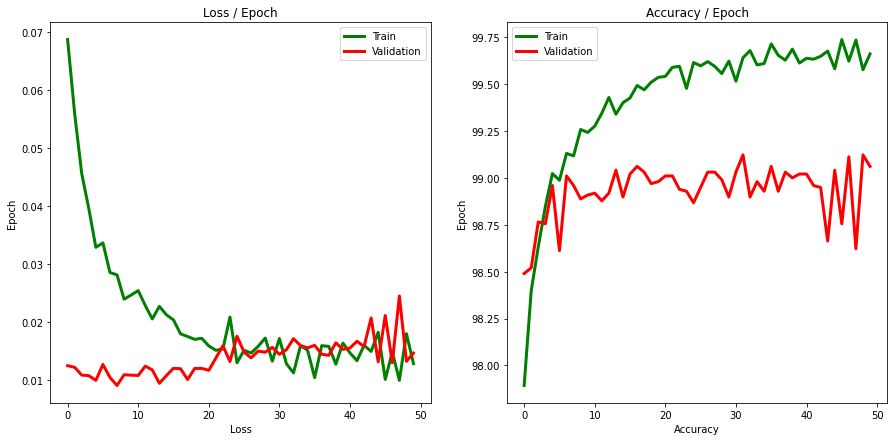

In [118]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()